---
title: Exploratory Work
description: ''
date: '2021-05-24T14:48:41.559Z'
authors:
  - name: Steve Purves
    userId: fI5cWFyZPEZCTpIHdqX5H8OU3Iv1
    orcid: 0000-0002-0760-5497
name: ef-exploratory-nb
oxa: oxa:dvunfvCkr67W5YDXfxGE/ztSGrPdIpp9w4bJ0m2Vg
---

# Efficient Frontier Workflow Notebook - Execution Ready

#### Modern Portfolio Theory

Modern Portfolio Theory (MPT) is an investment theory developed by Harry Markowitz and published under the title "Portfolio Selection" in the Journal of Finance in 1952.

Modern portfolio theory says that it is not enough to look at the expected risk and return of one particular stock. By investing in more than one stock, an investor can reap the benefits of diversification – chief among them, a reduction in the riskiness of the portfolio.

"risk of a portfolio is not equal to average/weighted-average of individual stocks in the portfolio". In terms of return, yes it is the average/weighted average of individual stock's returns, but that's not the case for risk. The risk is about how volatile the asset is, if you have more than one stock in your portfolio, then you have to take count of how these stocks movement correlates with each other. The beauty of diversification is that you can even get lower risk than a stock with the lowest risk in your portfolio, by optimising the allocation. 

## Setup & Data Loading

In [1]:
# oxa:imports
import pandas as pd  
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.optimize as sco

In [2]:
#oxa:globals
np.random.seed(777)
sns.set_style("whitegrid")
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In order to run the below code block, you will need your own API key. The stocks selected for this post is Apple, Amazon, Google, Facebook. Below code block will get daily adjusted closing price of each stock from 01/01/2016 to 31/12/2017.

In [3]:
#oxa:data-load
import quandl
quandl.ApiConfig.api_key = 'zCYyKsBbzk94ye5yRjvs'
stocks = ['AAPL','AMZN','GOOGL','FB']
data = quandl.get_table('WIKI/PRICES', ticker = stocks,
                        qopts = { 'columns': ['date', 'ticker', 'adj_close'] },
                        date = { 'gte': '2016-1-1', 'lte': '2017-12-31' }, paginate=True)
data.head()

,date,ticker,adj_close
None,,,
0,2017-12-29,GOOGL,1053.40
1,2017-12-28,GOOGL,1055.95
2,2017-12-27,GOOGL,1060.20
3,2017-12-26,GOOGL,1065.85
4,2017-12-22,GOOGL,1068.86


By looking at the info() of data, it seems like the "date" column is already in datetime format.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2006 entries, 0 to 2005
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   date       2006 non-null   datetime64[ns]
 1   ticker     2006 non-null   object        
 2   adj_close  2006 non-null   float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 47.1+ KB


In [5]:
df = data.set_index('date')
df.head()

,ticker,adj_close
date,,
2017-12-29,GOOGL,1053.40
2017-12-28,GOOGL,1055.95
2017-12-27,GOOGL,1060.20
2017-12-26,GOOGL,1065.85
2017-12-22,GOOGL,1068.86


## Screen Data

We expect to see data from our 4 stocks in separate columns

In [6]:
prices = df.pivot(columns='ticker')
# By specifying col[1] in below list comprehension
# You can select the stock names under multi-level column
prices.columns = [col[1] for col in prices.columns]
prices.head(10)

,AAPL,AMZN,FB,GOOGL
date,,,,
2016-01-04,101.783763,636.99,102.22,759.44
2016-01-05,99.233131,633.79,102.73,761.53
2016-01-06,97.291172,632.65,102.97,759.33
2016-01-07,93.185040,607.94,97.92,741.00
2016-01-08,93.677776,607.05,97.33,730.91
2016-01-11,95.194629,617.74,97.51,733.07
2016-01-12,96.576222,617.89,99.37,745.34
2016-01-13,94.093220,581.81,95.44,719.57
2016-01-14,96.151117,593.00,98.37,731.39


Let's first look at how the price of each stock has evolved within give time frame.

<AxesSubplot:xlabel='date'>

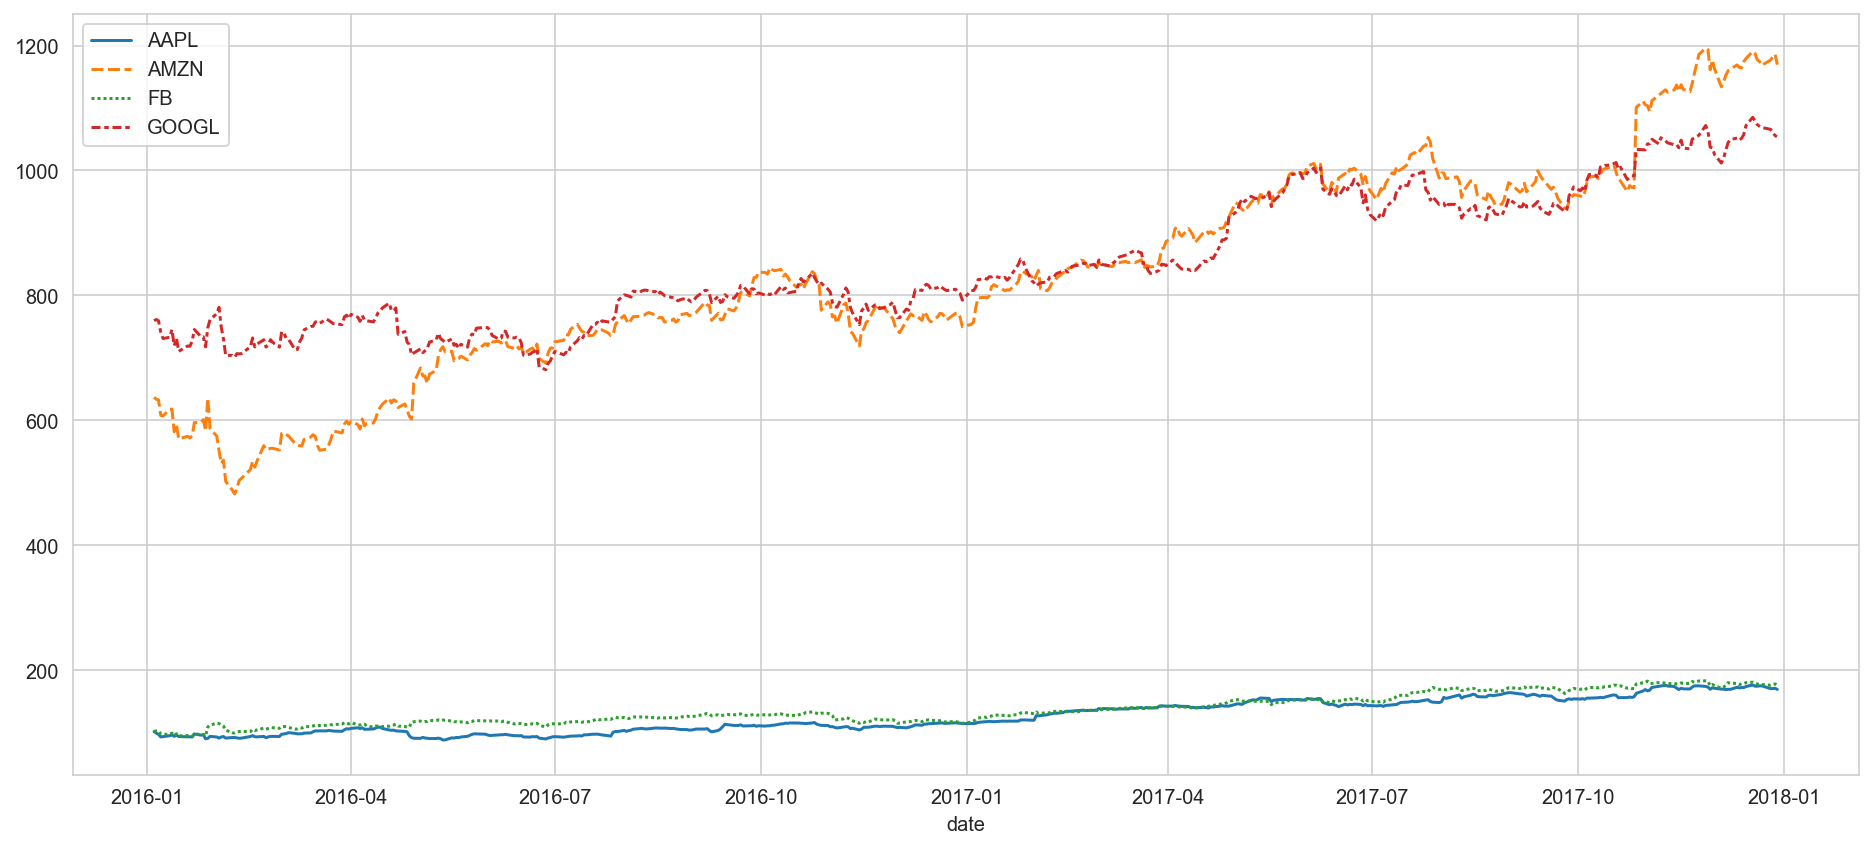

In [7]:
plt.figure(figsize=(16, 7))
sns.lineplot(data=prices, dashes=True)

It looks like that Amazon and Google's stock price is relatively more expensive than those of Facebook and Apple. But since Facebook and Apple are squashed at the bottom, it is hard to see the movement of these two. Another way to plot this is plotting daily returns (percent change compared to the day before). By plotting daily returns instead of actual prices, we can see the stocks' volatility.

<Figure size 1008x504 with 0 Axes>

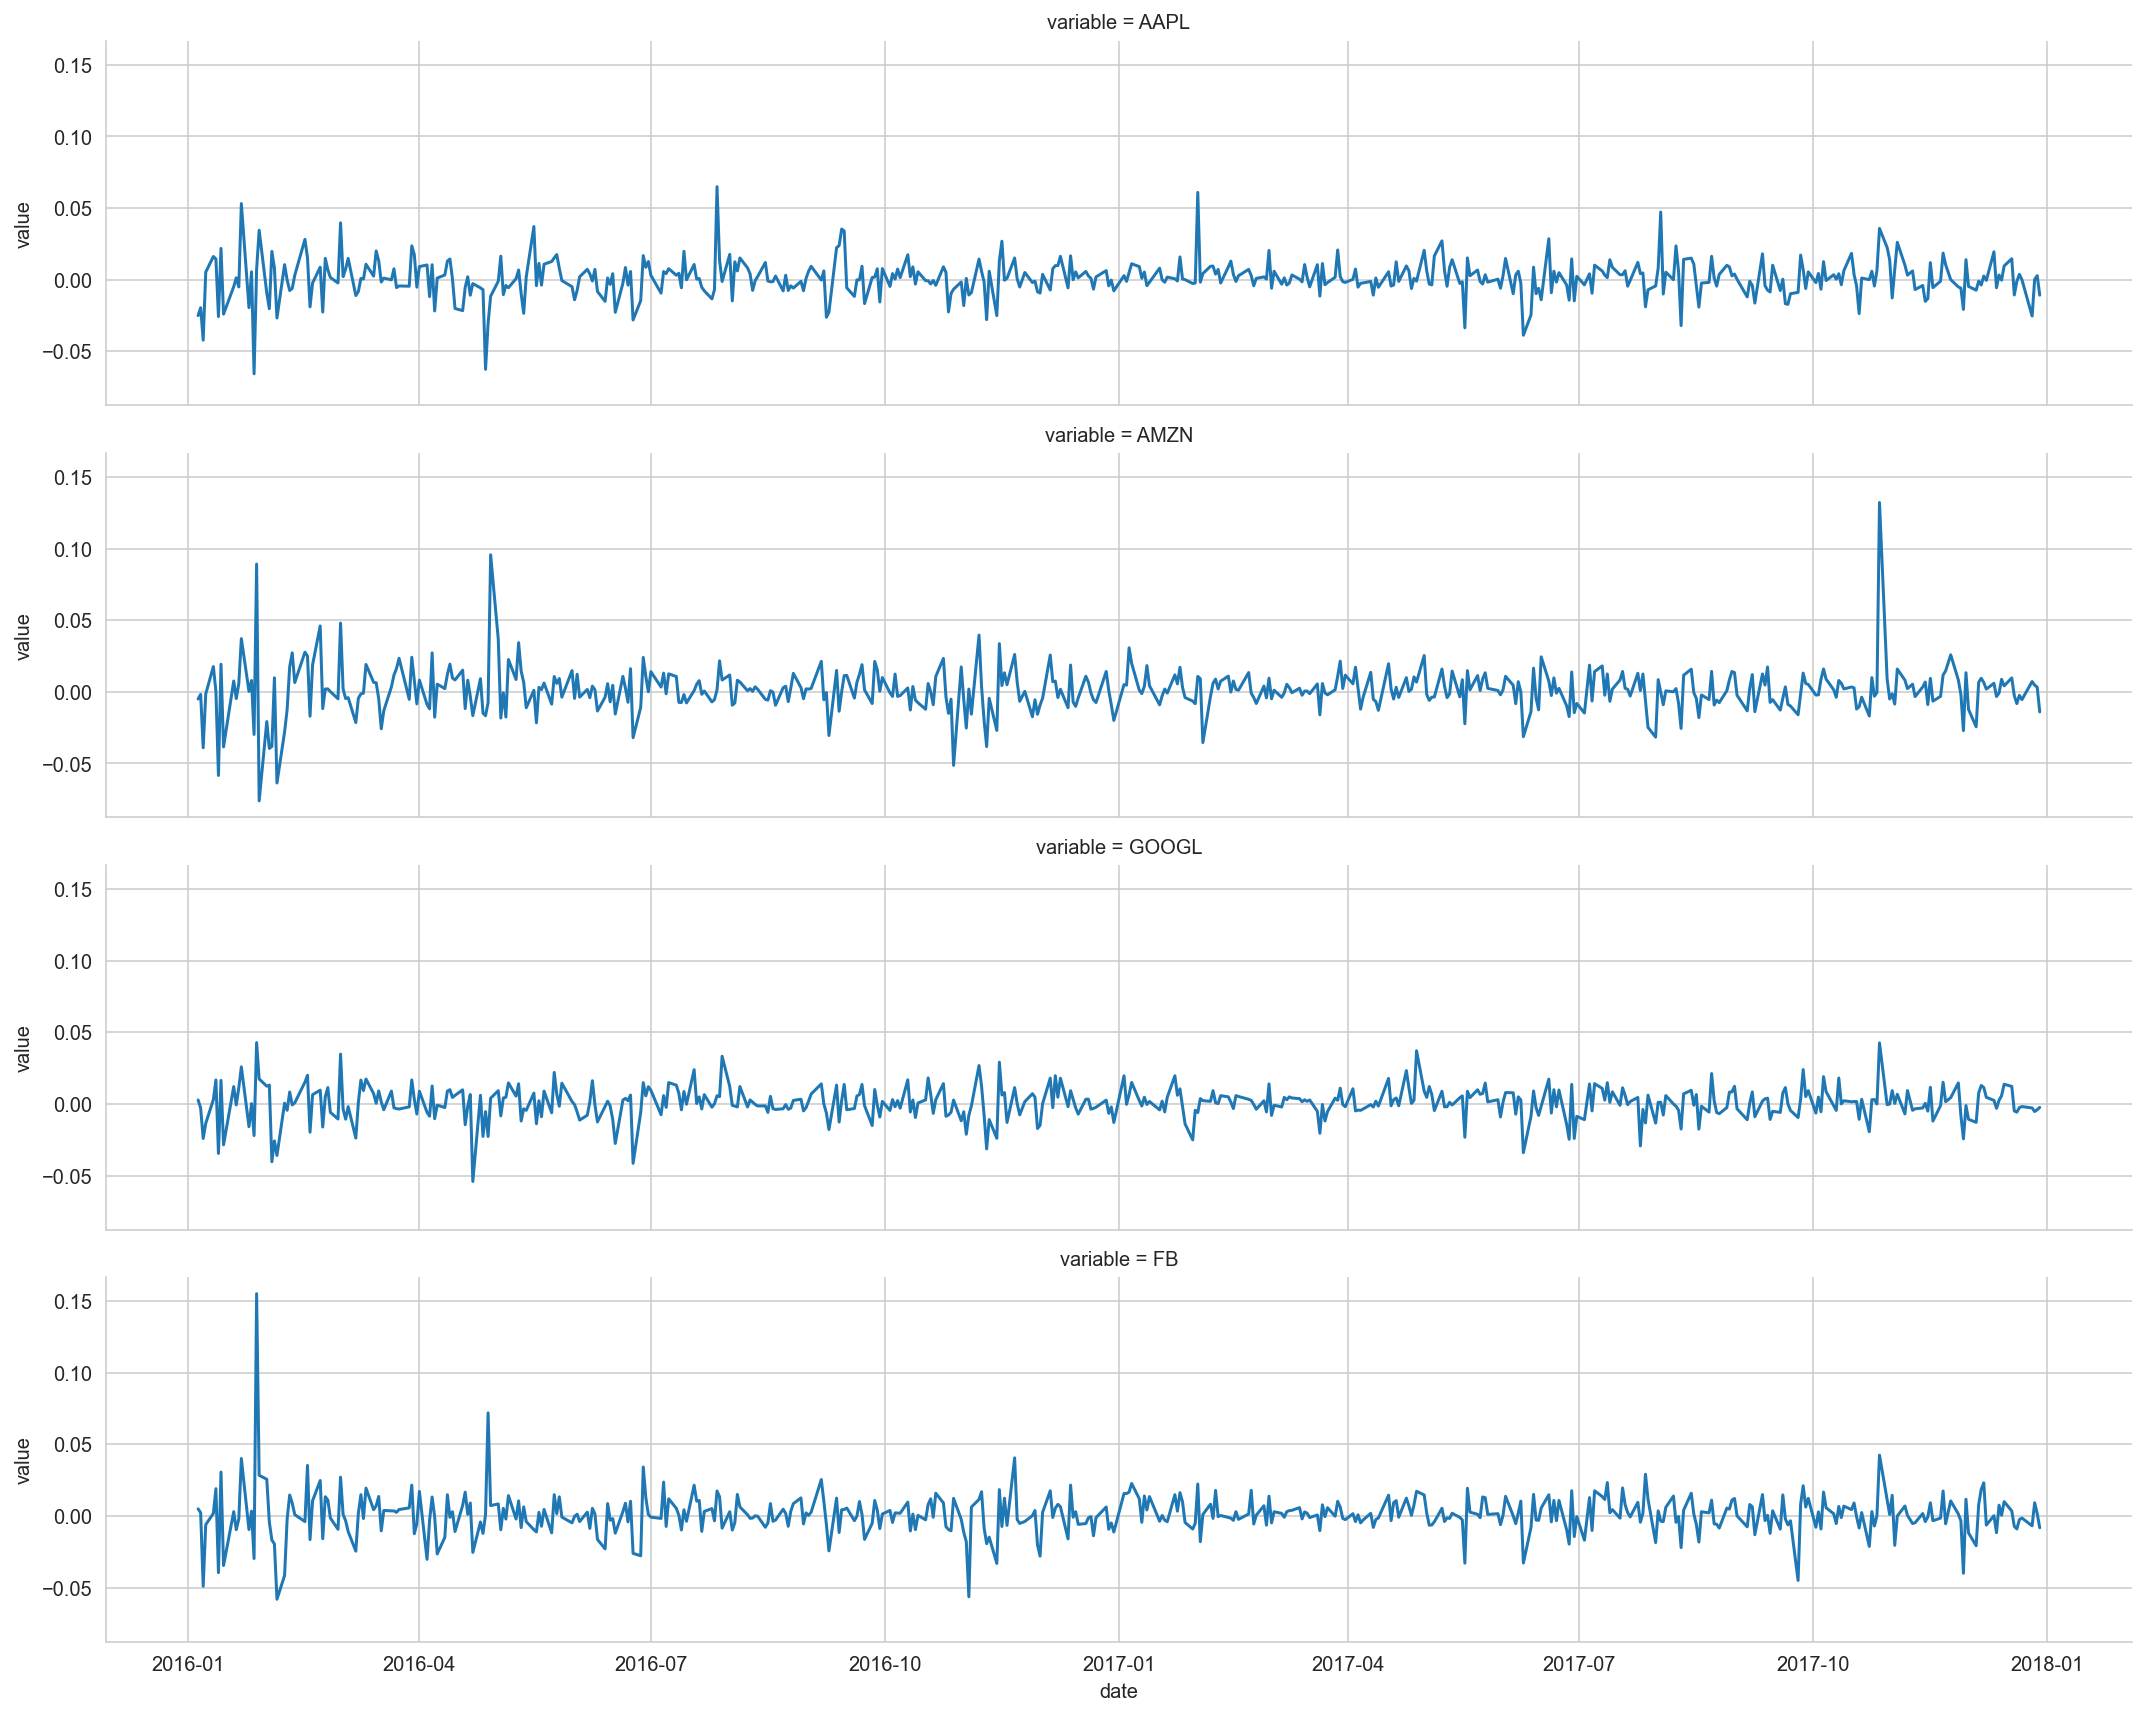

In [8]:
returns = prices.pct_change()

plt.figure(figsize=(14, 7))
g = sns.FacetGrid(data=returns.reset_index().melt(id_vars='date', value_vars=stocks), row="variable", aspect=5, sharex=True)
g.map(sns.lineplot, 'date', 'value')

Amazon has two distinctive positive spikes and a couple of negative ones. Facebook has one highest positive spike. And Google seems to be the least volatile.

## Random Portfolios Generation

We have 4 stocks in our portfolio. One decision we have to make is how we should allocate our budget to each of stock in our portfolio. If our total budget is 1, then we can decide the weights for each stock, so that the sum of weights will be 1. And the value for weights will be the portion of budget we allocate to a specific stock. For example, if weight is 0.5 for Amazon, it means that we allocate 50% of our budget to Amazon.

Let's define some functions to simulate random weights to each stock in the portfolio, then calculate the portfolio's overall annualised returns and annualised volatility.

"portfolio_annual_performance" function will calculate the returns and volatility, and to make it as an annualised calculation I take into account 252 as the number of trading days in one year. "random_portfolios" function will generate portfolios with random weights assigned to each stock, and by passing num_portfolios argument, you can decide how many random portfolios you want to generate.

In [12]:
def portfolio_annualised_performance(weights, mean_returns, cov_matrix):
    returns = np.sum(mean_returns*weights ) *252
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) * np.sqrt(252)
    return std, returns

In [10]:
def random_portfolios(num_portfolios, mean_returns, cov_matrix, risk_free_rate):
    results = np.zeros((3,num_portfolios))
    weights_record = []
    for i in range(num_portfolios):
        weights = np.random.random(4)
        weights /= np.sum(weights)
        weights_record.append(weights)
        portfolio_std_dev, portfolio_return = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
        results[0,i] = portfolio_std_dev
        results[1,i] = portfolio_return
        results[2,i] = (portfolio_return - risk_free_rate) / portfolio_std_dev
    return results, weights_record

You can easily get daily returns by calling pct_change on the data frame with the price data. And the mean daily returns, the covariance matrix of returns are needed to calculate portfolio returns and volatility. Finally, let's generate 25,000 portfolios with random weights assigned to each stock.

In [11]:
returns = prices.pct_change()
mean_returns = returns.mean()
cov_matrix = returns.cov()
num_portfolios = 5000
risk_free_rate = 0.0178

<AxesSubplot:>

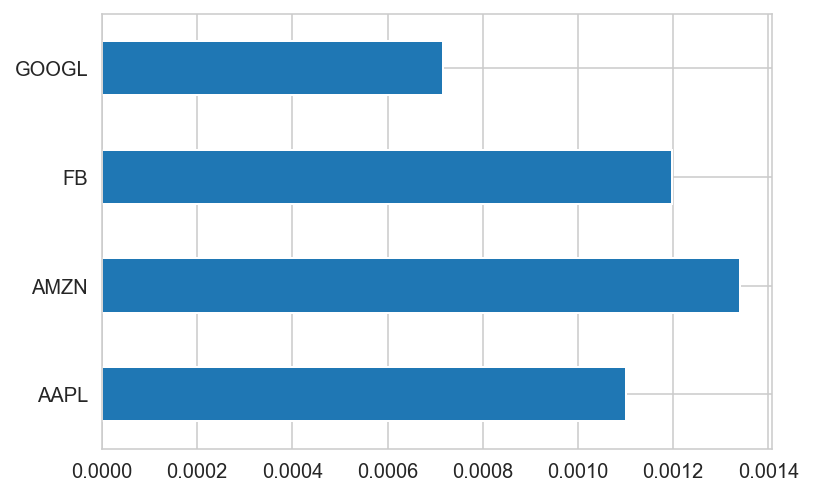

In [12]:
mean_returns.plot.barh()

<AxesSubplot:>

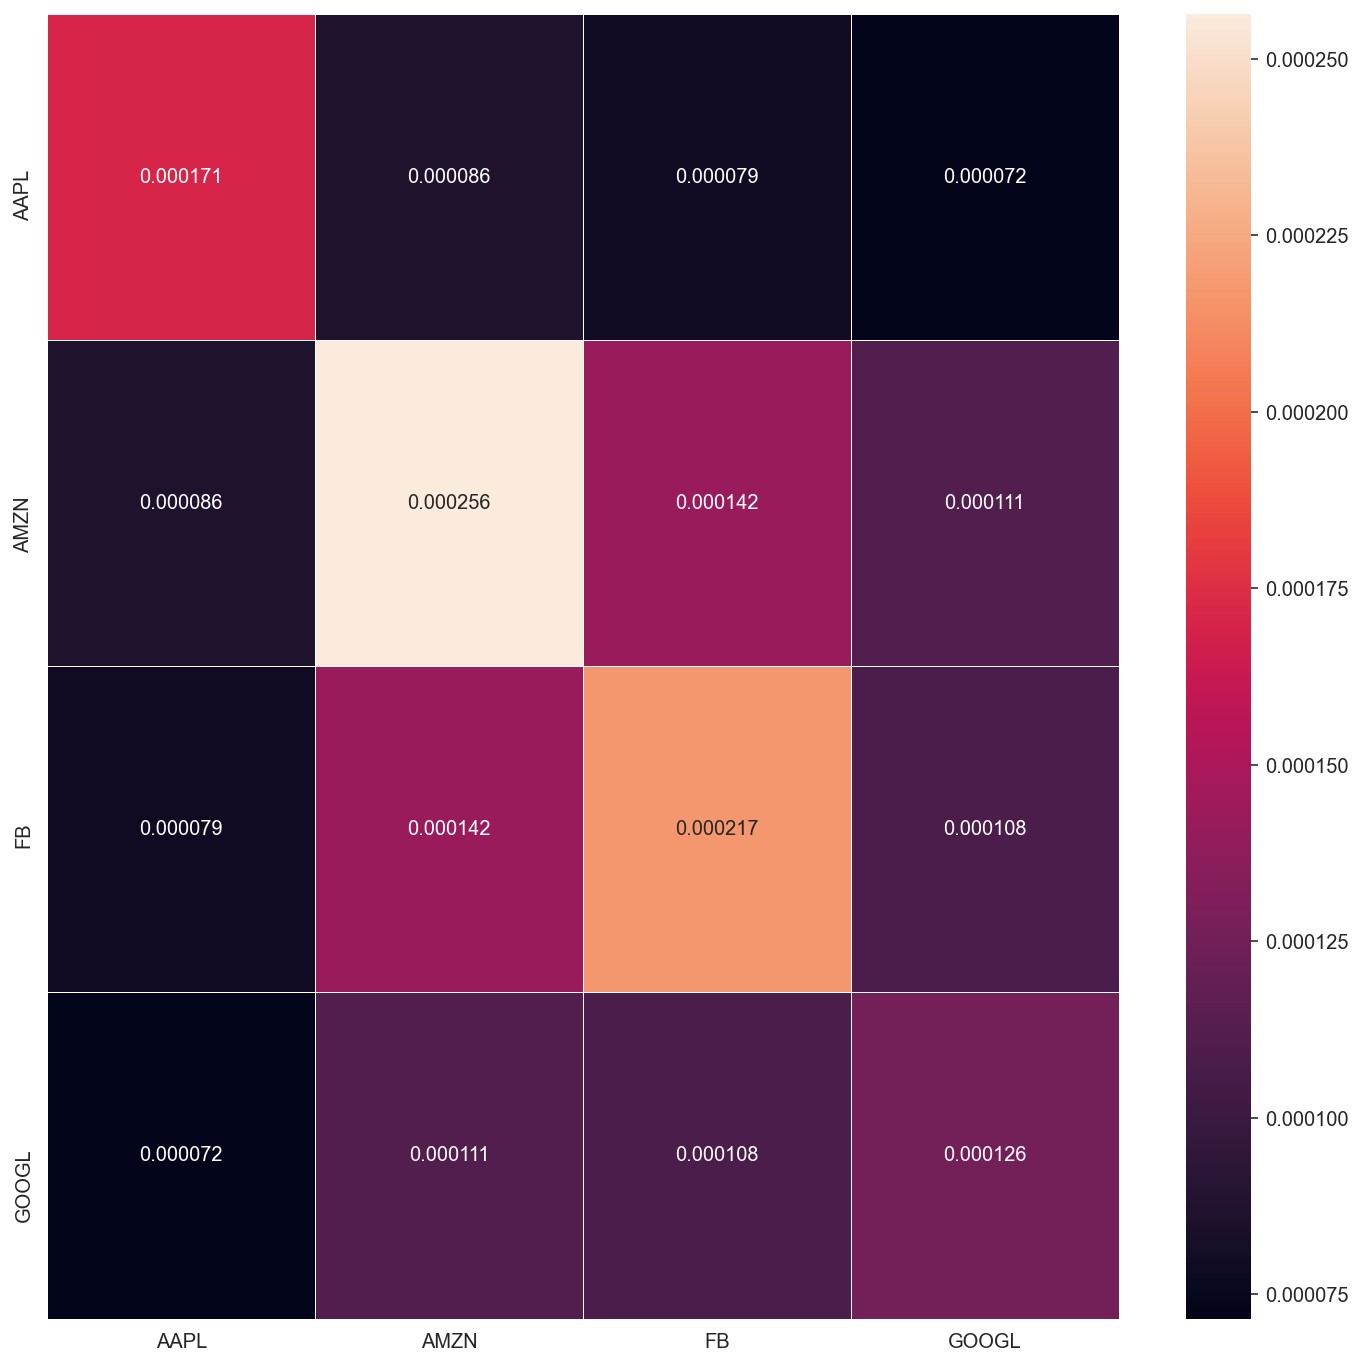

In [13]:
f, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(cov_matrix, annot=True, fmt="f", linewidths=.5, ax=ax)

The function below works as follows:

 - it generates random portfolio and gets the results (portfolio returns, portfolio volatility, portfolio Sharpe ratio) and weights for the corresponding result.
 - it finds the portfolio with highest Sharpe ratio portfolio
 - and the portfolio with the minimum volatility

In [22]:
def calc_simulated_ef_with_random(mean_returns, cov_matrix, num_portfolios, risk_free_rate):
    results, weights = random_portfolios(num_portfolios,mean_returns, cov_matrix, risk_free_rate)
    
    max_sharpe_idx = np.argmax(results[2])
    sdp, rp = results[0,max_sharpe_idx], results[1,max_sharpe_idx]
    max_sharpe_allocation = pd.DataFrame(weights[max_sharpe_idx],index=prices.columns,columns=['allocation'])
    max_sharpe_allocation.allocation = [round(i*100,2)for i in max_sharpe_allocation.allocation]
    max_sharpe_allocation = max_sharpe_allocation.T
    
    min_vol_idx = np.argmin(results[0])
    sdp_min, rp_min = results[0,min_vol_idx], results[1,min_vol_idx]
    min_vol_allocation = pd.DataFrame(weights[min_vol_idx],index=prices.columns,columns=['allocation'])
    min_vol_allocation.allocation = [round(i*100,2)for i in min_vol_allocation.allocation]
    min_vol_allocation = min_vol_allocation.T
    
    return results, weights, rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation


results, weights, rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation = calc_simulated_ef_with_random(
    mean_returns, cov_matrix, num_portfolios, risk_free_rate)

In [15]:
def print_row(a, b, c):
    return f"<tr><td>{a}</td><td>{b}</td><td>{c}</td></tr>"

def print_results_as_table(rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation):
    from IPython.core.display import display, HTML
    rows = \
        print_row("Annualised Return", round(rp,2), round(rp_min,2)) + \
        print_row("Annualised Volatility", round(sdp,2), round(sdp_min,2)) + \
        print_row("Allocations", "", "") + \
        print_row("AAPL", max_sharpe_allocation['AAPL'][0], min_vol_allocation['AAPL'][0]) + \
        print_row("AMZN", max_sharpe_allocation['AMZN'][0], min_vol_allocation['AMZN'][0]) + \
        print_row("FB", max_sharpe_allocation['FB'][0], min_vol_allocation['FB'][0]) + \
        print_row("GOOGL", max_sharpe_allocation['GOOGL'][0], min_vol_allocation['GOOGL'][0])
    
    display(HTML('''
        <div>
            <h3>Optimal Portfolio Allocations</h3>
            <table>
                <thead>
                    <th>Description</th>
                    <th>Max Sharpe Ratio</th>
                    <th>Minimum Volatility</th>
                </thead>
                <tbody>'''+rows+'''
                </tbody>
            </table>
        </div>'''))
    
    
print_results_as_table(rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation)

Annualised Return,0.3,0.23
Annualised Volatility,0.18,0.16
Allocations,,
AAPL,43.93,36.57
AMZN,29.49,2.16
FB,26.51,5.91
GOOGL,0.07,55.37


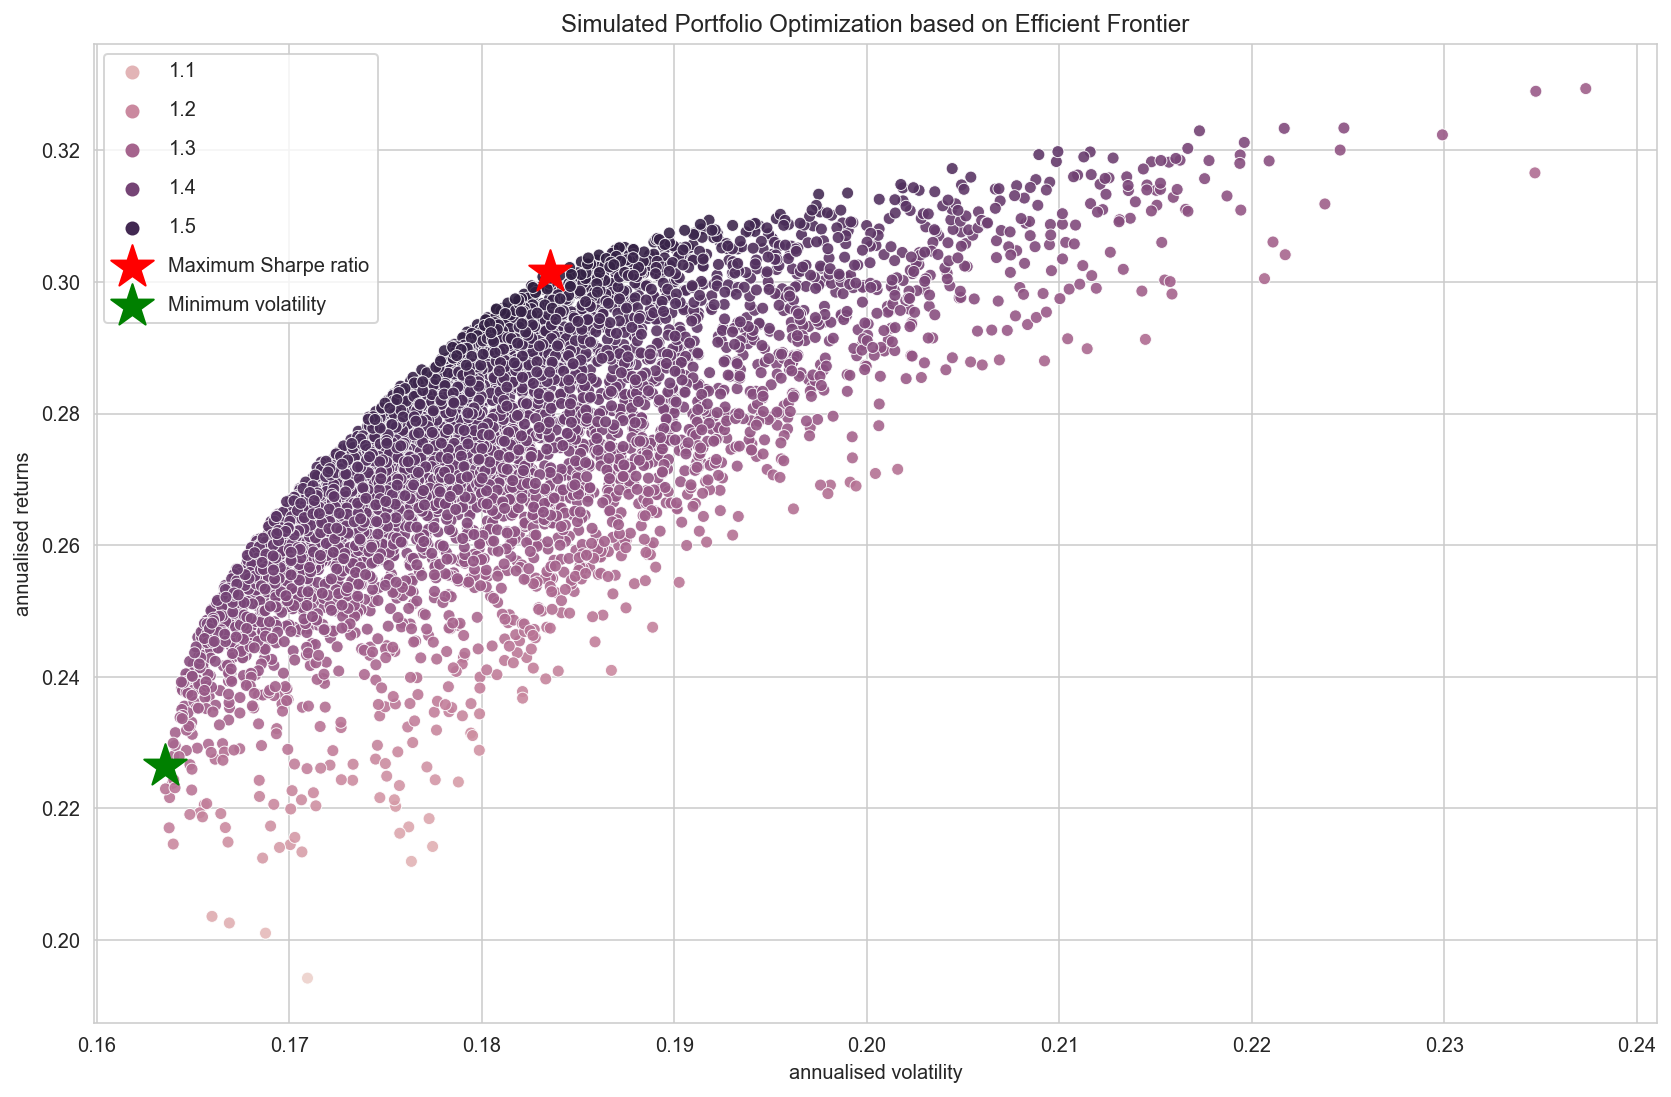

In [16]:
def plot_results(results, rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation):
    plt.figure(figsize=(14, 9))
    sdf = pd.DataFrame(dict(vol=results[0,:], ret=results[1,:], sharpe=results[2,:]))
    sns.scatterplot(data=sdf, x="vol", y="ret", hue="sharpe", alpha=0.9,  marker='o', sizes=20)
    plt.scatter(sdp,rp,marker='*',color='r',s=500, label='Maximum Sharpe ratio')
    plt.scatter(sdp_min,rp_min,marker='*',color='g',s=500, label='Minimum volatility')
    plt.title('Simulated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=1)

plot_results(results, rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation)

For minimum risk portfolio, more than half of our budget is allocated to Google.

If you take another look at the daily return plot from earlier, you can see that Google is the least volatile stock of four, so allocating a large percentage to Google for minimum risk portfolio makes intuitive sense.

If we are willing to take higher risk for higher return, one that gives us the best risk-adjusted return is the one with maximum Sharpe ratio.

In this scenario, we are allocating a significant portion to Amazon and Facebook, which are quite volatile stocks from the previous plot of daily returns. And Google which had more than 50% allocation in the minimum risk portfolio, has less than 1% budget allocated to it.

## Efficient Frontier

From the plot of the randomly simulated portfolio, we can see an upper boundary line along the edge of the blue dots. This line is called efficient frontier. Points along the line will give you the lowest risk for a given target return. 

All the other dots right to the line will give you higher risk with same returns. If the expected returns are the same, why would you take an extra risk when there's an option with lower risk?

Below functions are to get the maximum Sharpe ratio portfolio.

In Scipy's optimize function, there's no 'maximize', so as an objective function you need to pass something that should be minimized. That is why the first "neg_sharpe_ratio" is computing the negative Sharpe ratio. Now we can use this as our objective function to minimize. 

In [13]:
def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    p_var, p_ret = portfolio_annualised_performance(weights, mean_returns, cov_matrix)
    return -(p_ret - risk_free_rate) / p_var

def max_sharpe_ratio(mean_returns, cov_matrix, risk_free_rate):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix, risk_free_rate)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))
    result = sco.minimize(neg_sharpe_ratio, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)
    return result

In [14]:
def portfolio_volatility(weights, mean_returns, cov_matrix):
    return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[0]

def min_variance(mean_returns, cov_matrix):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)
    constraints = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bound = (0.0,1.0)
    bounds = tuple(bound for asset in range(num_assets))

    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args,
                        method='SLSQP', bounds=bounds, constraints=constraints)

    return result

We can also draw a line which depicts where the efficient portfolios for a given risk rate should be.

This is called "efficient frontier", the functions below calculate and plot the efficient frontier.

The first function "efficient_return" is calculating the most efficient portfolio for a given target return, 
and the second function "efficient_frontier" will take a range of target returns and compute efficient portfolio for each return level.

In [15]:
def efficient_return(mean_returns, cov_matrix, target):
    num_assets = len(mean_returns)
    args = (mean_returns, cov_matrix)

    def portfolio_return(weights):
        return portfolio_annualised_performance(weights, mean_returns, cov_matrix)[1]

    constraints = ({'type': 'eq', 'fun': lambda x: portfolio_return(x) - target},
                   {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    bounds = tuple((0,1) for asset in range(num_assets))
    result = sco.minimize(portfolio_volatility, num_assets*[1./num_assets,], args=args, method='SLSQP', bounds=bounds, constraints=constraints)
    return result


def efficient_frontier(mean_returns, cov_matrix, returns_range):
    efficients = []
    for ret in returns_range:
        efficients.append(efficient_return(mean_returns, cov_matrix, ret))
    return efficients

Let's try to plot the portfolio choice with maximum Sharpe ratio and minimum volatility also with all the randomly generated portfolios. But this time we are not picking the optimal ones from the randomly generated portfolios, but we are actually calculating by using Scipy's 'minimize' function. And the below function will also plot the efficient frontier line.

In [218]:
def plot_efficient_frontier(mean_returns, cov_matrix):
    target = np.linspace(rp_min, 0.34, 50)
    efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
    plt.plot([p['fun'] for p in efficient_portfolios], target, linestyle='-.', linewidth=3, color='black', label='efficient frontier')
    plt.title('Calculated Portfolio Optimization based on Efficient Frontier')
    plt.xlabel('annualised volatility')
    plt.ylabel('annualised returns')
    plt.legend(labelspacing=0.8)

Let's re-display the randomised postfolios plot from above with the frontier overlaid

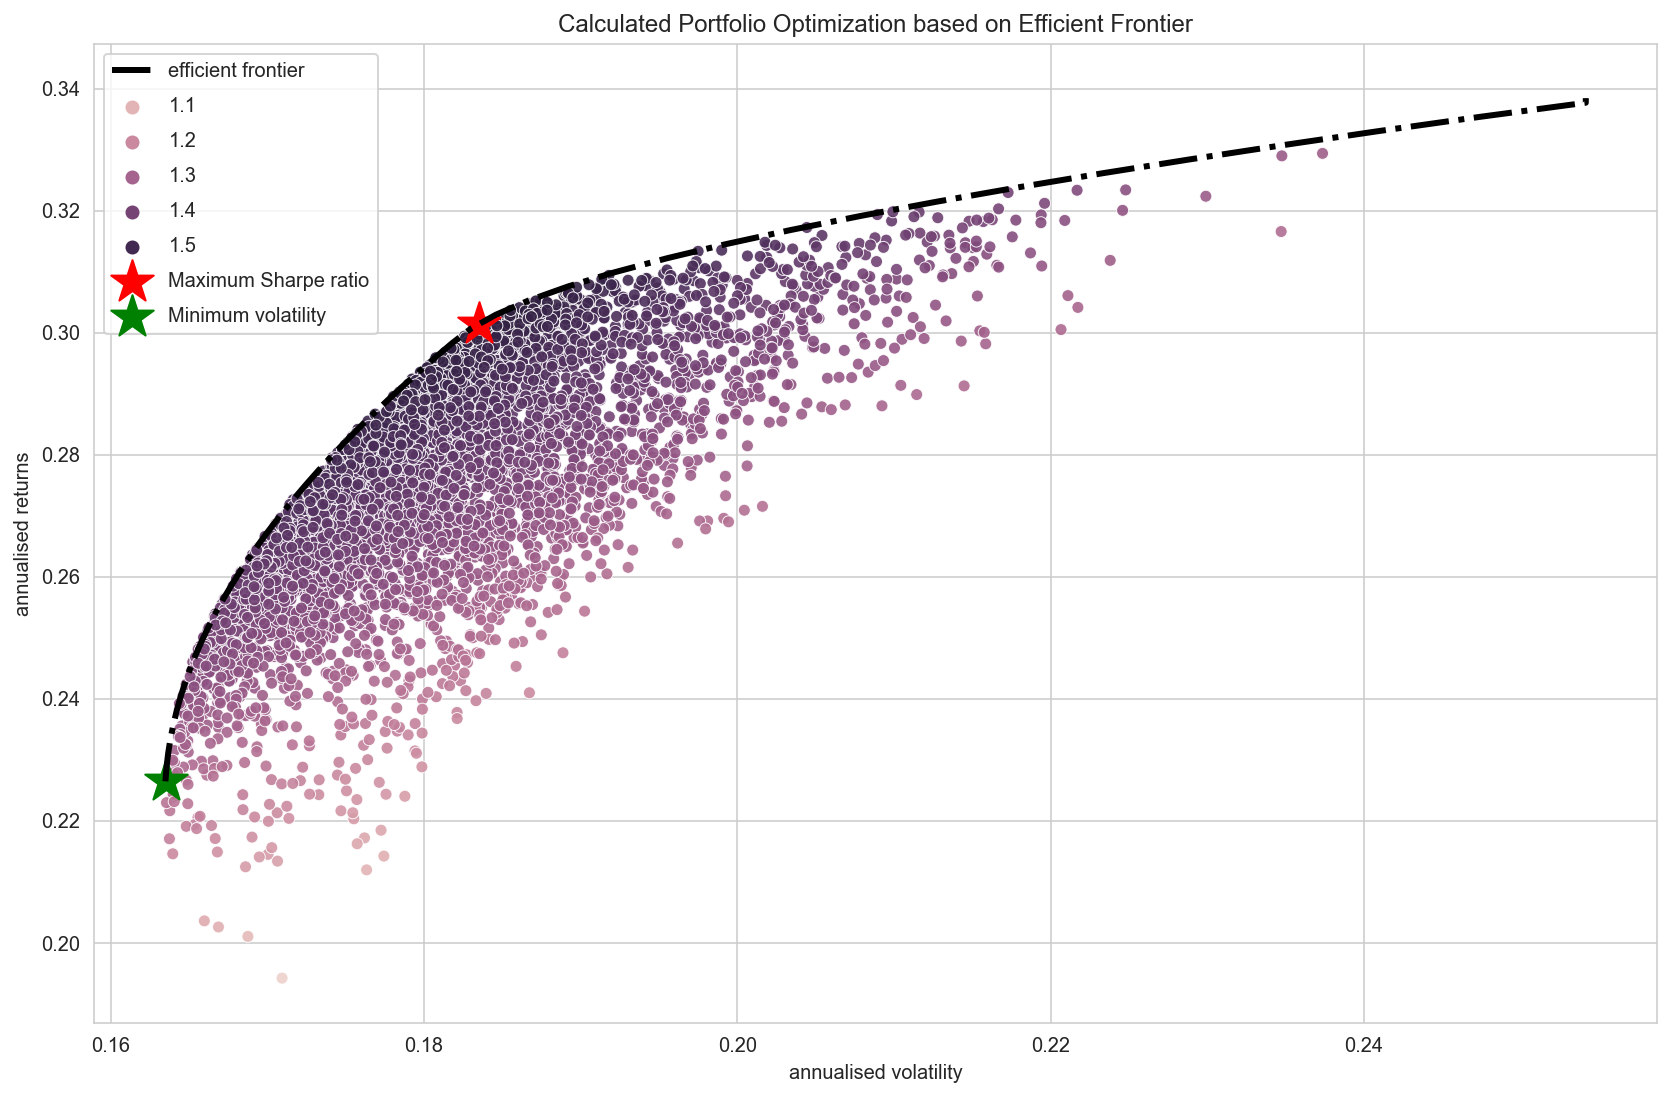

In [21]:
plot_results(results, rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation)
plot_efficient_frontier(mean_returns, cov_matrix)

We have almost the same result as what we have simulated by picking from the randomly generated portfolios. The slight difference is that the Scipy's "optimize" function has not allocated any budget at all for Google on maximum Sharpe ratio portfolio, while one we chose from the randomly generated samples has 0.45% of allocation for Google. There are some differences in the decimal places but more or less same.

Instead of plotting every randomly generated portfolio, we can plot each individual stocks on the plot with the corresponding values of each stock's annual return and annual risk. This way we can see and compare how diversification is lowering the risk by optimising the allocation.

In [35]:
def plot_individual_stocks(returns, mean_returns, rp, sdp, rp_min, sdp_min):
    an_vol = np.std(returns) * np.sqrt(252)
    an_rt = mean_returns * 252
    plt.scatter(an_vol,an_rt,marker='o',s=200, c='red')
    for i, txt in enumerate(prices.columns):
        plt.annotate(txt, (an_vol[i],an_rt[i]), xytext=(10,0), textcoords='offset points')


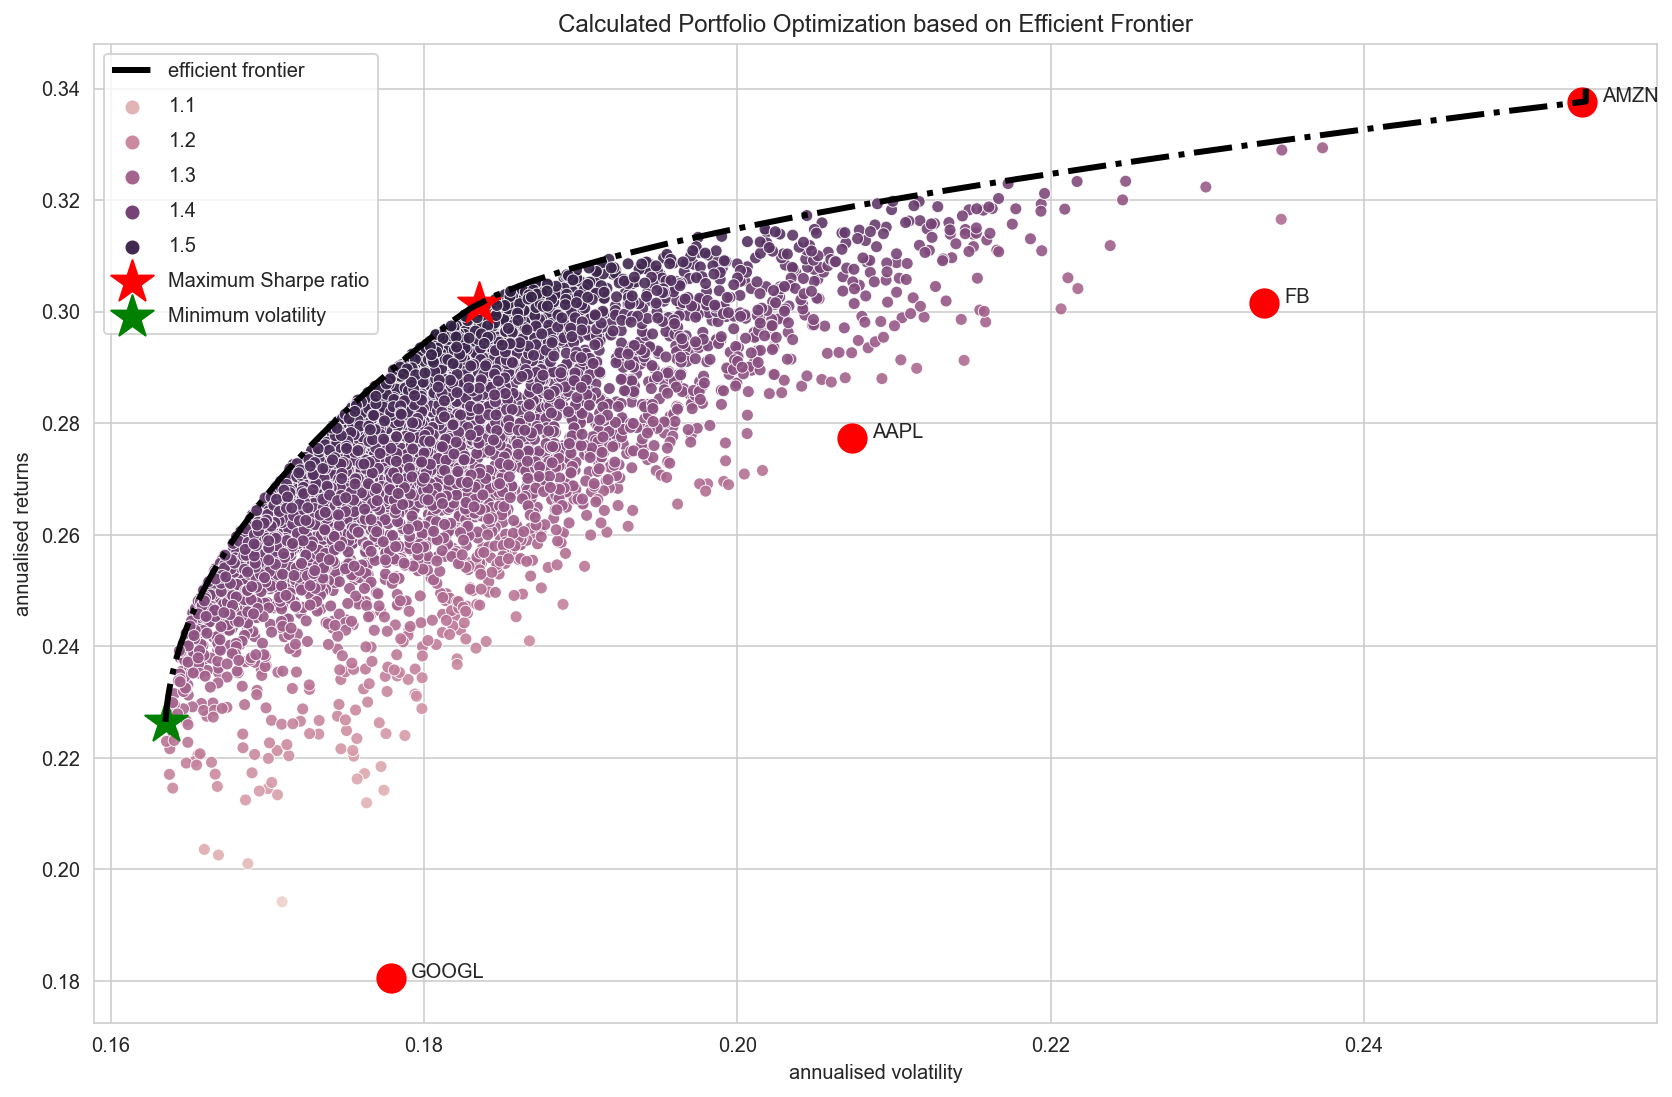

In [23]:
plot_results(results, rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation)
plot_efficient_frontier(mean_returns, cov_matrix)
plot_individual_stocks(returns, mean_returns, rp, sdp, rp_min, sdp_min)

The stock with the least risk is Google at around 0.18. 

But with portfolio optimisation, a lower risk of 0.16 cannbe acheived with a higher return than Google. 

For a slight increase in risk at around the similar level of risk of Google, we can achieve a much higher return of 0.30 with portfolio optimization.

In [24]:
print_results_as_table(rp, sdp, max_sharpe_allocation, rp_min, sdp_min, min_vol_allocation)

Annualised Return,0.3,0.23
Annualised Volatility,0.18,0.16
Allocations,,
AAPL,43.93,36.57
AMZN,29.49,2.16
FB,26.51,5.91
GOOGL,0.07,55.37


### Prep data and code up interactive plot with Altair

In [25]:
# computed efficient frontier
target = np.linspace(rp_min, 0.34, 50)
efficient_portfolios = efficient_frontier(mean_returns, cov_matrix, target)
frontier = [p["fun"] for p in efficient_portfolios]

ef_df = pd.DataFrame(dict(volatility=frontier, retrn=target))
ef_df.head()

,volatility,retrn
0,0.163504,0.226457
1,0.163574,0.228774
2,0.163681,0.231091
3,0.163826,0.233408
4,0.164009,0.235725


In [26]:
# individual stock performance
an_vol = np.std(returns) * np.sqrt(252)
an_rt = mean_returns * 252

ind_df = pd.DataFrame(dict(volatility=an_vol, retrn=an_rt)).reset_index()
ind_df.head()

,index,volatility,retrn
0,AAPL,0.207339,0.277337
1,AMZN,0.253904,0.337612
2,FB,0.233615,0.301557
3,GOOGL,0.177916,0.180504


In [49]:
import altair as alt
alt.data_transformers.disable_max_rows()


sdf = pd.DataFrame(dict(volatility=results[0,:], retrn=results[1,:], sharpe=results[2,:]))
brush = alt.selection_interval()

scatter = alt.Chart(sdf).mark_circle(size=40, stroke="white", strokeWidth=1).encode(
    x=alt.X('volatility:Q', scale=alt.Scale(zero=False)),
    y=alt.Y('retrn:Q', scale=alt.Scale(zero=False), title="return"),
    color=alt.condition(brush, 'sharpe', alt.value('lightgray')),
    tooltip=[
        alt.Tooltip('volatility', title="Volatility", format=".3"),
        alt.Tooltip('retrn', title="Return", format=".3"),
        alt.Tooltip('sharpe', title="Sharpe Ratio", format=".3")],
).add_selection(
    brush
).properties(
    width=780,
    height=400
)

ef = alt.Chart(ef_df).mark_line(color="black", strokeDash=[10,5,1,5]).encode(
    x="volatility:Q",
    y="retrn:Q",
)

opt_sdp_df = pd.DataFrame(dict(sdp=[sdp], rp=[rp]))
opt_sdp = alt.Chart(opt_sdp_df).mark_circle(size=300,color="red").encode(
    x="sdp:Q",
    y="rp:Q"
)
opt_sdp_txt = opt_sdp.mark_text(
    align='right',
    baseline='bottom',
    dx=-8,
    fontSize=16,
    text="Optimum Sharpe Ratio"
).encode(
    x="sdp:Q",
    y="rp:Q"
)


min_vol_df = pd.DataFrame(dict(sdp=[sdp_min], rp=[rp_min]))
min_vol = alt.Chart(min_vol_df).mark_circle(size=300,color="green").encode(
    x="sdp:Q",
    y="rp:Q"
)
min_vol_txt = min_vol.mark_text(
    align='left',
    baseline='top',
    dx=5,
    dy=5,
    fontSize=16,
    text="Minimum Volatility"
).encode(
    x="sdp:Q",
    y="rp:Q"
)

ind = alt.Chart(ind_df).mark_circle(size=300, color="blue").encode(
    x="volatility:Q",
    y="retrn:Q",
    text="index"
)

ind_txt = ind.mark_text(
    align='left',
    baseline='middle',
    dx=10,
    dy=-5,
    fontSize=14,
).encode(
    text="index"
)

volatility = alt.Chart(sdf).mark_bar().encode(
    x='count()',
    y=alt.Y("volatility:Q", bin=alt.Bin(extent=[0.16, 0.24], step=0.0025), title="Volatility"),
    color='sharpe'
).transform_filter(
    brush
).properties(
    width=220,
    height=220
)

retrns = alt.Chart(sdf).mark_bar().encode(
    x='count()',
    y=alt.Y("retrn:Q", bin=alt.Bin(extent=[0.18, 0.34], step=0.005), title="Returns"),
    color='sharpe'
).transform_filter(
    brush
).properties(
    width=220,
    height=220
)

sharpe = alt.Chart(sdf).mark_bar().encode(
    x='count()',
    y=alt.Y("sharpe:Q", bin=alt.Bin(extent=[1, 1.6], step=0.01), title="Sharpe Ratio"),
    color='sharpe',
).transform_filter(
    brush
).properties(
    width=220,
    height=220
)


alt.vconcat(
    scatter + ef + opt_sdp + opt_sdp_txt + min_vol + min_vol_txt + ind + ind_txt,
    alt.hconcat(volatility, retrns, sharpe, title="Variable Distributions (for Selection)"),
    title="Calculated Portfolio Optimisation based on Efficient Frontier")


alt.VConcatChart(...)

## Attribution

This notebook is based on a [blog article written by Ricky Kim](https://towardsdatascience.com/optimizing-portfolios-with-modern-portfolio-theory-using-python-60ce9a597808).